In [1]:
# Read and clean the data
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import LabelEncoder

# Label encoding for string values
def LabelEncoding(col):
        lbl_enc = LabelEncoder()
        lbl_enc.fit(col)
        cat_col = lbl_enc.transform(col)
        return cat_col

def clean_my_df(df):

    numeric_features = df._get_numeric_data()
    
    # Normalize the scale of numeric values. 
    numeric_features = (numeric_features) / (numeric_features.max())
    categorical_features = df.select_dtypes(include=['object'])

    for col_name in categorical_features.columns :
        categorical_features[col_name] = categorical_features[col_name].astype("category",
                                        categories=pd.unique(categorical_features[col_name].values.ravel()))
        data_oneHot = pd.get_dummies(categorical_features[col_name]) # One hot encoding
        numeric_features = pd.concat([numeric_features,data_oneHot],axis = 1)

    return numeric_features


data = pd.read_csv("data.csv")
data.drop(["Customer"],axis = 1, inplace = True)
data.drop(["Effective To Date"],axis = 1, inplace = True)
labels = pd.DataFrame({"Response":LabelEncoding(data["Response"])})
data.drop(["Response"],axis = 1, inplace = True)
features = clean_my_df(data)

/home/devaraj/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


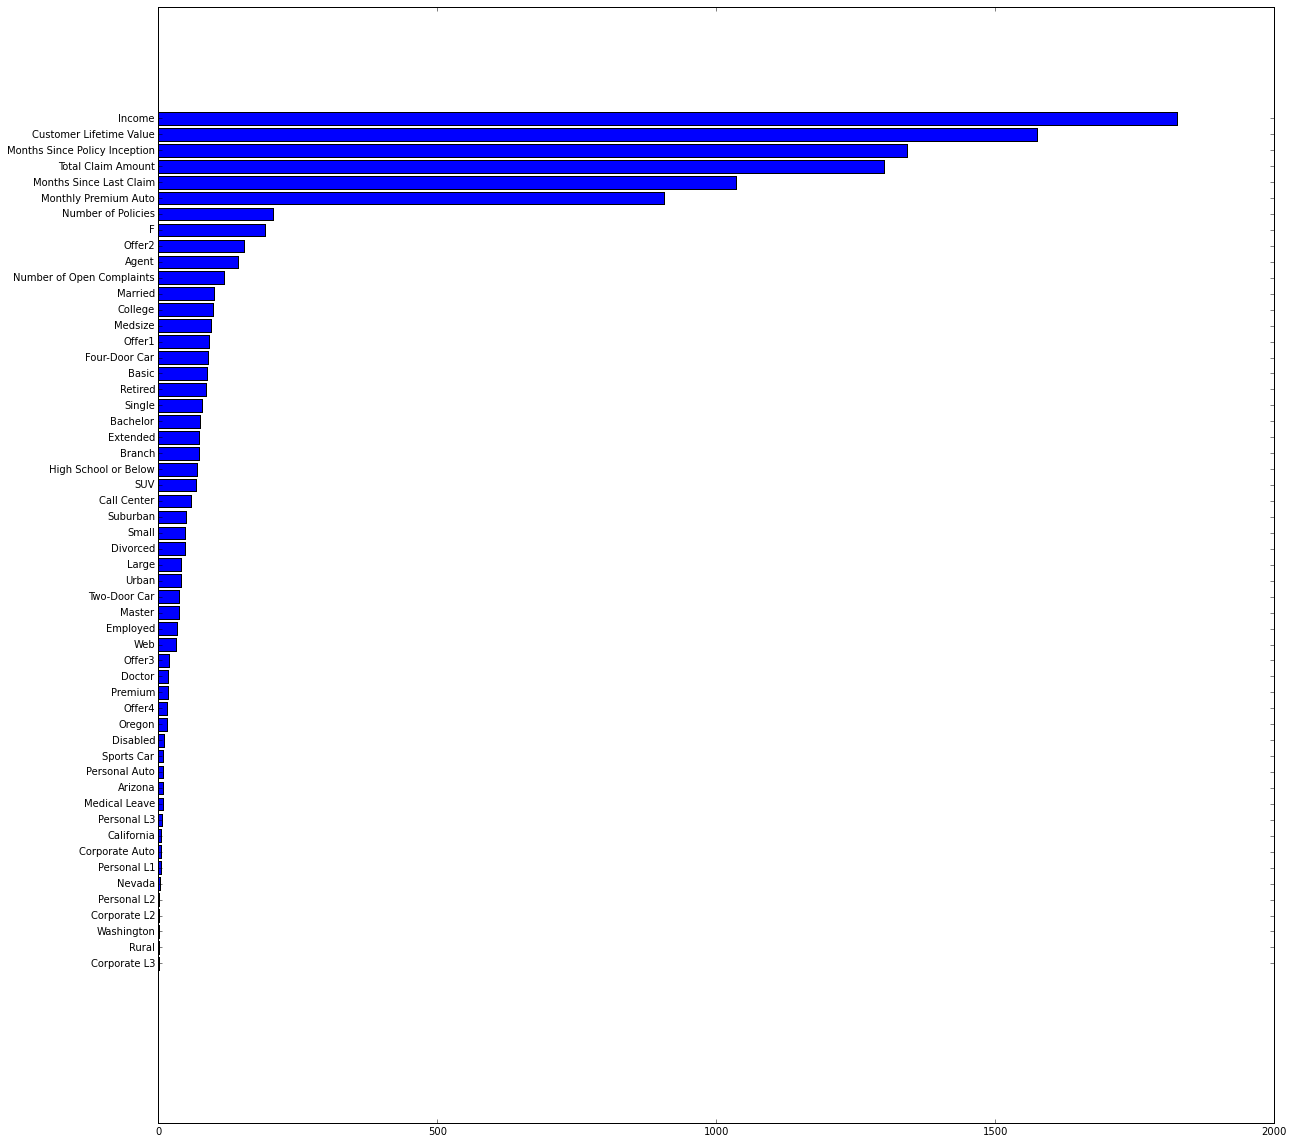

In [2]:
#Feature Importances
import xgboost as xgb
from collections import OrderedDict

# Check feature importances for the classifier.
xgb_params = {"objective": "binary:logistic","max_depth": 8}
num_rounds = 1000
xg_train = xgb.DMatrix(features,label=labels)
bst = xgb.train(xgb_params, xg_train, num_rounds)
importances = bst.get_fscore()
importances = OrderedDict(sorted(importances.items(), key=lambda x: x[1]))

# Plot the importan features with fscore
plt.figure(figsize=(20,20))
plt.barh(range(len(importances)), importances.values(), align='center')
plt.yticks(range(len(importances)),importances.keys())
plt.show()

In [3]:
# Important Features
imp_features = features[importances.keys()[-30:]]
print imp_features.columns

Index([u'Urban', u'Large', u'Divorced', u'Small', u'Suburban', u'Call Center',
       u'SUV', u'High School or Below', u'Branch', u'Extended', u'Bachelor',
       u'Single', u'Retired', u'Basic', u'Four-Door Car', u'Offer1',
       u'Medsize', u'College', u'Married', u'Number of Open Complaints',
       u'Agent', u'Offer2', u'F', u'Number of Policies',
       u'Monthly Premium Auto', u'Months Since Last Claim',
       u'Total Claim Amount', u'Months Since Policy Inception',
       u'Customer Lifetime Value', u'Income'],
      dtype='object')


In [4]:
# Parameter Tuning
from sklearn.cross_validation import *
from sklearn.metrics import *
from sklearn.grid_search import GridSearchCV
from pprint import pprint

# List of hyperparametres
xgb_model = xgb.XGBClassifier()
parameters = {'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.01,0.1],
              'max_depth': [6,9],
              'min_child_weight': [5,8],
              'subsample': [0.6,0.75],
              'colsample_bytree': [0.75,0.9],
              'n_estimators': [10]
              }

# Scoring function for evaluation
def score_func(model, X, y_true) :
    preds = model.predict(X)
    return accuracy_score(y_true,preds)

# This step is used as Gridsearch does not handle well with nupy arrays
labels = np.array([l[0] for l in labels.values.tolist()])

# Grid Search using stratified K fold
clf = GridSearchCV(xgb_model,parameters,n_jobs=4,cv=StratifiedKFold(labels,n_folds=4, shuffle=True),
                   scoring=score_func,refit=True)
clf.fit(imp_features,labels)
best_parameters,score,filler = max(clf.grid_scores_,key=lambda x:x[1])

#Get Best hyper parameters
print "score:", score, "\n"
pprint(best_parameters)

score: 0.897865669842 

{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_weight': 5,
 'n_estimators': 10,
 'nthread': 4,
 'objective': 'binary:logistic',
 'subsample': 0.75}


Note : Parameter tuning can be improved by taking more values of the hyperparameters, but it takes too much time. Therefore using only few values to demonstarte the procedure. 

In [33]:
#classification Report
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split

# Split the files into training and testing
x_train, x_test, y_train, y_test = train_test_split(imp_features,labels)

d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test)

# Use best parameters from hyperparameter tuning
param = best_parameters
param['n_estimators'] = 10

bst = xgb.train(param,d_train)
pred = bst.predict(d_test)
pred_transformed = []

# Transform the probabilites to class labels.
for i in range(len(pred)) : 
    if pred[i] > 0.5 :
        pred_transformed.append(1)
    else :
        pred_transformed.append(0)

#Get Classification Report
pred_transformed = np.array(pred_transformed)
print(classification_report(y_test,pred_transformed))

             precision    recall  f1-score   support

          0       0.91      0.99      0.95      1788
          1       0.90      0.39      0.55       286

avg / total       0.91      0.91      0.89      2074



The recall of 1 (i.e response YES) is low due to less number of samples of that class. 